Playing with decision trees.

In [1]:
import pandas as pd

In [2]:
from sklearn import datasets
iris = datasets.load_iris()

In [3]:
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [4]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [6]:
df['target'] = pd.Series(iris.target)

In [7]:
df.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
100,6.3,3.3,6.0,2.5,2
124,6.7,3.3,5.7,2.1,2
135,7.7,3.0,6.1,2.3,2
1,4.9,3.0,1.4,0.2,0
89,5.5,2.5,4.0,1.3,1


In [8]:
df['target names'] = df['target'].apply(lambda y : iris.target_names[y])

In [9]:
df.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target names
130,7.4,2.8,6.1,1.9,2,virginica
47,4.6,3.2,1.4,0.2,0,setosa
63,6.1,2.9,4.7,1.4,1,versicolor
56,6.3,3.3,4.7,1.6,1,versicolor
14,5.8,4.0,1.2,0.2,0,setosa


In [10]:
df['target names'].unique()  #three output labels

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [11]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size= 0.3)

In [12]:
xtrain = df_train[iris.feature_names]
xtest = df_test[iris.feature_names]

ytrain = df_train['target']
ytest = df_test['target']

In [13]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

In [14]:
clf.fit(xtrain, ytrain)

DecisionTreeClassifier()

In [15]:
ytest_pred = clf.predict(xtest)

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ytest_pred)

0.9333333333333333

In [17]:
pd.DataFrame({'feature_names' : iris.feature_names, 'feature_importances' : clf.feature_importances_}).sort_values('feature_importances', ascending= False ).set_index('feature_names')

,feature_importances
feature_names,
petal length (cm),0.953132
sepal length (cm),0.033397
petal width (cm),0.013471
sepal width (cm),0.000000


Prevent Overfitting: Allowing a tree to grow so much results in overfitting. To prevent it, we can set hyperparametres like __max_depth__ , __min_samples_split__ , __min_samples_leaf__ 

#### Shuffle split
 - in sklearn, it performs Monte Carlo cross - validation. Monte Carlo methods make use of random sampling in order to repeat an experiment over and over to reach better estimates for the results


"Cross-validation is a technique that involves systematically generating multiple train and test splits from the dataset to evaluate the model's performance on unseen data."

In [18]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

clf = DecisionTreeClassifier()

rs = ShuffleSplit(n_splits=100, test_size=0.3)  #here, we randomly split the dataset into 100 training and test pairs
x = df[iris.feature_names]
y = df['target']

cv_results = cross_validate(clf, x, y, cv = rs, scoring="accuracy")

accuracy_scores = pd.Series(cv_results['test_score'])

In [19]:
accuracy_scores.mean()

0.9473333333333334

<Axes: title={'center': 'Distribution of Classifier Accuracy'}>

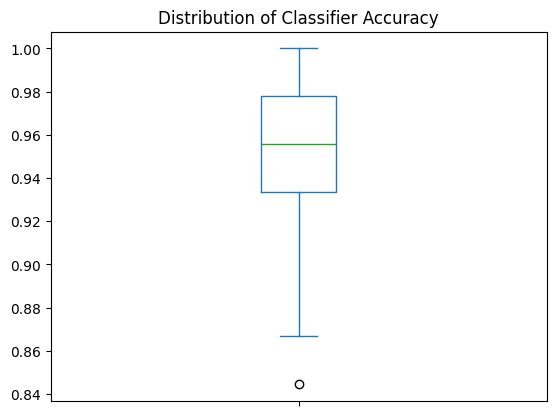

In [20]:
accuracy_scores.plot(title = 'Distribution of Classifier Accuracy', kind = 'box')

## Trying different hyperparameter values

In [21]:
x = df[iris.feature_names]
y = df['target']

xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=.25)

clf = DecisionTreeClassifier()

clf.fit(xtrain, ytrain)

DecisionTreeClassifier()

In [22]:
clf.get_depth()

4

Looping over the max depth from 1 to 5 and use __Shuffle_Split__ to get the classfier accuracy

In [23]:
for max_depth in [1,2,3,4,5]:
    clf = DecisionTreeClassifier(max_depth=max_depth)

    rs = ShuffleSplit(n_splits=20, test_size=.25)

    cv_results = cross_validate(clf, xtrain, ytrain, cv = rs, scoring = 'accuracy')

    accuracy_scores = pd.Series(cv_results['test_score'])
    
    print(f"@ max_depth = {max_depth}: accuracy_scores = {accuracy_scores.quantile(.1)} ~ {accuracy_scores.quantile(.9)}")

@ max_depth = 1: accuracy_scores = 0.5678571428571428 ~ 0.6464285714285716
@ max_depth = 2: accuracy_scores = 0.925 ~ 1.0
@ max_depth = 3: accuracy_scores = 0.8928571428571429 ~ 0.967857142857143
@ max_depth = 4: accuracy_scores = 0.8928571428571429 ~ 1.0
@ max_depth = 5: accuracy_scores = 0.925 ~ 1.0


In [24]:
#calculating accuray with max_depth = 3

clf = DecisionTreeClassifier(max_depth=3)

rs = ShuffleSplit(n_splits=100, test_size=0.3) 
x = df[iris.feature_names]
y = df['target']

cv_results = cross_validate(clf, x, y, cv = rs, scoring="accuracy")

accuracy_scores = pd.Series(cv_results['test_score'])

In [25]:
accuracy_scores.mean()

0.9508888888888888

## Visualizing the tree's decision boundaries

In [26]:
import numpy as np 
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, x, y):
    feature_names = x.columns
    x, y = x.values , y.values

    x_min , x_max = x[:,0].min() , x[:, 0].max()
    y_min , y_max = x[:,1].min() , x[:, 1].max()

    step = 0.02

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, step),
        np.arange(y_min, y_max, step)
    )

    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    
    # Plot decision boundaries
    plt.figure(figsize=(12,8))
    plt.contourf(xx, yy, z, cmap='Paired_r', alpha=0.25)
    plt.contour(xx, yy, z, colors = 'k', linewidths=0.7)
    plt.scatter(x[:, 0], x[:, 1], c=y, edgecolor='k')
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title('Decision Tree Decision Boundaries')
    plt.show()

c:\Users\melwi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


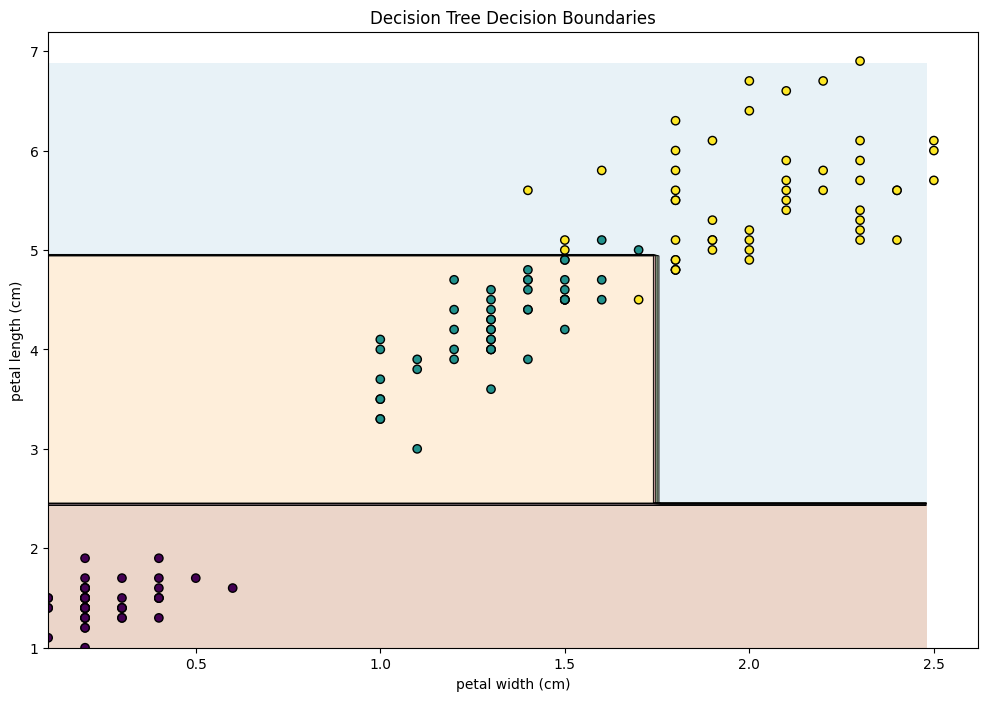

In [27]:
#only using two features

x = df[['petal width (cm)', 'petal length (cm)'] ]
y = df['target']

clf = DecisionTreeClassifier(max_depth = 3)
clf.fit(x, y)

plot_decision_boundary(clf, x, y)
